# Lecture: Complex Network Analysis

Prof. Dr. Michael Gertz

Winter Semester 2021/22

## Assignment 7 - Assortativity and Robustness

### Problem 7-3: Xalvi-Brunet and Sokolov Algorithm

Students: Felix Hausberger, Nils Krehl, Patrick Günther

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import scipy

# 1. Xalvi-Brunet and Sokolov algorithm

In [2]:
def xalvi_brunet_sokolov_algorithm(graph, num_iterations, assortative):
    network = graph.copy()
    for i in range(num_iterations):
        links = np.array(list(network.edges))
        degrees = network.degree()
        # choose two random links
        choosen_indices = np.random.choice(range(len(links)), 2, replace=False)
        choosen_links = links[choosen_indices]
        
        # get corresponding nodes and their node degrees
        corresponding_nodes = choosen_links.flatten()
        corresponding_node_degrees = np.array([degrees[x] for x in corresponding_nodes])
        
        # sort the nodes by their degrees in descending order
        index_array = np.argsort(corresponding_node_degrees)[::-1]
        ordered_nodes = corresponding_nodes[index_array]
        ordered_nodes_degrees = corresponding_node_degrees[index_array]
        
        # remove the selected links
        network.remove_edge(choosen_links[0][0], choosen_links[0][1])
        network.remove_edge(choosen_links[1][0], choosen_links[1][1])
        
        # rewiring
        if assortative == True:
            network.add_edge(ordered_nodes[0], ordered_nodes[1])
            network.add_edge(ordered_nodes[2], ordered_nodes[3])
        else:
            network.add_edge(ordered_nodes[0], ordered_nodes[3])
            network.add_edge(ordered_nodes[1], ordered_nodes[2])
    
    return network

# 2. Create networks with Xalvi-Brunet and Sokolov algorithm

In [3]:
df_neutral_network = pd.read_csv('neutral_network.txt', delim_whitespace=True, header=None)

In [4]:
G_neutral_network = nx.Graph()
G_neutral_network.add_edges_from(df_neutral_network.itertuples(index=False))

In [5]:
G_assortative = xalvi_brunet_sokolov_algorithm(G_neutral_network, 5000, True)
G_disassortative = xalvi_brunet_sokolov_algorithm(G_neutral_network, 5000, False)

In [6]:
print("Degree Correlation Coefficient")
print("r = 0: neutral network; r < 0: disassortative network; r > 0: assortative network \n")
print("Neutral network Degree Correlation Coefficient: {}".format(nx.degree_pearson_correlation_coefficient(G_neutral_network)))
print("Assortative network Degree Correlation Coefficient: {}".format(nx.degree_pearson_correlation_coefficient(G_assortative)))
print("Disassortative network Degree Correlation Coefficient: {}".format(nx.degree_pearson_correlation_coefficient(G_disassortative)))

Degree Correlation Coefficient
r = 0: neutral network; r < 0: disassortative network; r > 0: assortative network 

Neutral network Degree Correlation Coefficient: -0.009246262701730106
Assortative network Degree Correlation Coefficient: 0.9037799701732246
Disassortative network Degree Correlation Coefficient: -0.6223530885853903


# 3. Plot giant component size

In [69]:
def get_giant_component_size(network):
    if network.number_of_nodes() > 0:
        giant_component = max(nx.connected_components(network), key=len)
        giant_component_size = len(giant_component)
        return giant_component_size
    else:
        return 0


def get_relative_size_of_giant_component(graph, num_samples=20):
    network = graph.copy()
    number_nodes = network.number_of_nodes()
    f = []
    
    relative_size_of_giant_component = []
    for f_value in np.arange(0,1.1,0.1):
        giant_component_size = []
        for sample in range(num_samples):
            minimized_network = network.copy()
            number_to_be_removed = int(f_value * number_nodes)
            
            random_sample = np.random.choice(minimized_network.nodes(), number_to_be_removed, replace=False)
            minimized_network.remove_nodes_from(random_sample)
            
            giant_component_size.append(get_giant_component_size(minimized_network))
        relative_size_of_giant_component.append(np.mean(np.array(giant_component_size)))
    
    return np.array(relative_size_of_giant_component) / 100
            
neutral_relative_size_of_giant_component = get_relative_size_of_giant_component(G_neutral_network)
assortative_relative_size_of_giant_component = get_relative_size_of_giant_component(G_assortative)
disassortative_relative_size_of_giant_component = get_relative_size_of_giant_component(G_disassortative)

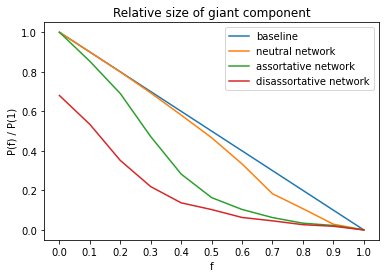

In [71]:
plt.plot(np.arange(10,-1,-1) / 10, label="baseline")
plt.plot(neutral_relative_size_of_giant_component, label="neutral network")
plt.plot(assortative_relative_size_of_giant_component, label="assortative network")
plt.plot(disassortative_relative_size_of_giant_component, label="disassortative network")
plt.xticks(ticks=range(11), labels=(np.arange(0,11,1) / 10))
plt.legend()
plt.title("Relative size of giant component")
plt.xlabel("f")
plt.ylabel("P(f) / P(1)")
plt.show()

# 4. Discussion

Discuss the results from the previous task: Which network is the most robust against random failures? Explain why this is the case.

The most robust network against random failues is the neutral network.
In a neutral network nodes are linked randomly and consequently the density of links is around the average degree. 

In assortative networks hubs tend to link to each other and small-degree nodes tend to connect to small degree nodes.

In disassortative networks hubs avoid each other. Small-degree nodes tend to connect to hubs, and hubs tend to connect to
small-degree nodes (this is called hub-and-spoke character). 
